In [1]:
from src.rejax.envs.bernoulli_bandit import BernoulliBandit, EnvParams
from rejax import get_algo
from rejax.evaluate import evaluate

import jax
import jax.numpy as jnp
import numpy as np
import yaml

In [2]:
config_path = "/Users/chanb/research/ualberta/sandbox/rejax/configs/custom/bandit.yaml"

with open(config_path, "r") as f:
    config = yaml.safe_load(f.read())

In [3]:
algo_name = "ucb"
seed_id = 0
num_seeds = 10
num_arms = 5

key = jax.random.PRNGKey(seed_id)
keys = jax.random.split(key, num_seeds)
config = config[algo_name]

In [4]:
config

{'agent_kwargs': {'confidence': 1.0},
 'total_timesteps': 1000000,
 'eval_freq': 1000}

In [ ]:
env = BernoulliBandit()
config["env"] = env

env_params = jax.random.uniform(key, shape=(num_seeds, num_arms))

algo_cls = get_algo(algo_name)
algo = jax.vmap(
    lambda x: algo_cls.create(
        **config,
        env_params=EnvParams(reward_probs=x),
    )
)(
    env_params
)


def eval_callback(algo, ts, rng):
    act = algo.make_act(ts)
    max_steps = algo.env_params.max_steps_in_episode
    return evaluate(act, rng, env, algo.env_params, 128, max_steps)

algo = algo.replace(
    eval_callback=eval_callback
)

In [6]:
algo

UCB(env=<src.rejax.envs.bernoulli_bandit.BernoulliBandit object at 0x127984100>, env_params=EnvParams(max_steps_in_episode=Array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32, weak_type=True), reward_probs=Array([[0.947667  , 0.9785799 , 0.33229148, 0.46866846, 0.5698887 ],
       [0.16550303, 0.3101946 , 0.68948054, 0.74676657, 0.17101455],
       [0.9853538 , 0.02528262, 0.6400418 , 0.56269085, 0.8992138 ],
       [0.93453753, 0.8341402 , 0.7256162 , 0.5098531 , 0.02765214],
       [0.03148878, 0.9580188 , 0.5188192 , 0.79221416, 0.5522419 ],
       [0.6113529 , 0.8931755 , 0.75499094, 0.21164179, 0.22934973],
       [0.06192303, 0.6189376 , 0.49173605, 0.54509854, 0.41268063],
       [0.5281111 , 0.80325234, 0.20560277, 0.49416995, 0.44019997],
       [0.1840241 , 0.22390449, 0.6304687 , 0.79081404, 0.51702666],
       [0.28174305, 0.33929098, 0.02611375, 0.9059328 , 0.77465725]],      dtype=float32)), eval_callback=<function eval_callback at 0x103fd8160>, eval_freq=1000, skip_initial

In [7]:
vmap_train = jax.jit(jax.vmap(algo_cls.train, in_axes=(0, 0)))
ts, (_, returns) = vmap_train(algo, keys)
returns.block_until_ready()

{'params': {'counts': Traced<float32[1,5]>with<DynamicJaxprTrace>, 'q_values': Traced<float32[1,5]>with<DynamicJaxprTrace>, 'timesteps': Traced<float32[]>with<DynamicJaxprTrace>}}


Array([[[1., 1., 1., ..., 1., 0., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 0., 0., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       [[0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 1., 1., ..., 1., 0., 0.],
        ...,
        [1., 1., 0., ..., 1., 1., 0.],
        [1., 1., 1., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       ...,

       [[1., 1., 1., ..., 0., 0., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 0., 1., 1.],
        [1., 1., 1., ..., 1., 0., 1.],
        [0., 1., 1., ..., 1., 1.

In [8]:
jax.vmap(lambda x: jax.numpy.mean(x, axis=-1)[-1])(returns)

Array([0.9453125, 0.6953125, 1.       , 0.9296875, 0.9765625, 0.8984375,
       0.6328125, 0.84375  , 0.828125 , 0.921875 ], dtype=float32)

In [14]:
np.argmax(env_params, axis=-1)

Array([1, 3, 0, 0, 1, 1, 1, 1, 3, 3], dtype=int32)

In [13]:
np.argmax(ts.agent_ts.params["params"]["counts"], axis=-1).T

Array([[1, 3, 0, 0, 1, 1, 1, 1, 3, 3]], dtype=int32)

In [15]:
np.argmax(ts.agent_ts.params["params"]["q_values"], axis=-1).T

Array([[1, 3, 0, 0, 1, 1, 1, 1, 3, 3]], dtype=int32)

In [10]:
jax.debug.print("{x}", x=ts.agent_ts.params)

{'params': {'counts': Array([[[2.38700e+04, 9.75803e+05, 4.30000e+01, 1.25000e+02,
         1.59000e+02]],

       [[6.90000e+01, 1.50000e+02, 6.34700e+03, 9.93345e+05,
         8.90000e+01]],

       [[9.95930e+05, 3.10000e+01, 2.22000e+02, 1.59000e+02,
         3.65800e+03]],

       [[9.96078e+05, 3.22500e+03, 5.31000e+02, 1.32000e+02,
         3.40000e+01]],

       [[3.20000e+01, 9.98411e+05, 1.37000e+02, 1.19800e+03,
         2.22000e+02]],

       [[1.71000e+02, 9.98337e+05, 1.37200e+03, 4.90000e+01,
         7.10000e+01]],

       [[8.40000e+01, 9.93521e+05, 1.29300e+03, 4.45100e+03,
         6.51000e+02]],

       [[2.11000e+02, 9.99124e+05, 7.10000e+01, 3.54000e+02,
         2.40000e+02]],

       [[7.30000e+01, 9.40000e+01, 9.06000e+02, 9.98622e+05,
         3.05000e+02]],

       [[5.70000e+01, 9.50000e+01, 3.80000e+01, 9.98191e+05,
         1.61900e+03]]], dtype=float32), 'q_values': Array([[[0.9436681 , 0.9723724 , 0.16279072, 0.5040001 , 0.5597484 ]],

       [[0.1159420

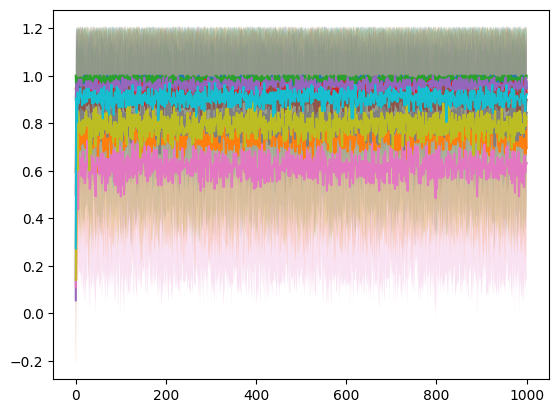

In [11]:
import matplotlib.pyplot as plt

for env_returns in returns:
    xrange = np.arange(len(env_returns))
    mean = np.mean(env_returns, axis=-1)
    std = np.std(env_returns, axis=-1)
    plt.plot(xrange, mean)
    plt.fill_between(xrange, mean - std, mean + std, alpha=0.2)
plt.show()
